In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run1",
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 154325,
    "seed": 154325,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 7000], examples_per_second: 352.3445, train_label_loss: 2.7976, 


epoch: 1, [batch: 700 / 7000], examples_per_second: 17317.2721, train_label_loss: 2.6081, 


epoch: 1, [batch: 1400 / 7000], examples_per_second: 17144.5221, train_label_loss: 2.4690, 


epoch: 1, [batch: 2100 / 7000], examples_per_second: 17189.5338, train_label_loss: 2.2814, 


epoch: 1, [batch: 2800 / 7000], examples_per_second: 17137.1849, train_label_loss: 2.1113, 


epoch: 1, [batch: 3500 / 7000], examples_per_second: 17040.6647, train_label_loss: 1.8761, 


epoch: 1, [batch: 4200 / 7000], examples_per_second: 16890.2229, train_label_loss: 1.6116, 


epoch: 1, [batch: 4900 / 7000], examples_per_second: 16909.3558, train_label_loss: 1.7628, 


epoch: 1, [batch: 5600 / 7000], examples_per_second: 16970.5752, train_label_loss: 1.4754, 


epoch: 1, [batch: 6300 / 7000], examples_per_second: 16973.7194, train_label_loss: 1.4425, 


epoch: 1, source_val_acc_label: 0.5756, source_val_label_loss: 1.2686, target_val_acc_label: 0.5756, target_val_label_loss: 1.2686, 


New best
epoch: 2, [batch: 1 / 7000], examples_per_second: 18.1853, train_label_loss: 1.3078, 


epoch: 2, [batch: 700 / 7000], examples_per_second: 16986.8442, train_label_loss: 1.3633, 


epoch: 2, [batch: 1400 / 7000], examples_per_second: 16865.0422, train_label_loss: 1.1544, 


epoch: 2, [batch: 2100 / 7000], examples_per_second: 16887.2614, train_label_loss: 1.3141, 


epoch: 2, [batch: 2800 / 7000], examples_per_second: 16922.5436, train_label_loss: 1.1710, 


epoch: 2, [batch: 3500 / 7000], examples_per_second: 16830.7438, train_label_loss: 1.0783, 


epoch: 2, [batch: 4200 / 7000], examples_per_second: 16773.1822, train_label_loss: 1.0363, 


epoch: 2, [batch: 4900 / 7000], examples_per_second: 16657.5900, train_label_loss: 0.9885, 


epoch: 2, [batch: 5600 / 7000], examples_per_second: 16559.2081, train_label_loss: 1.0587, 


epoch: 2, [batch: 6300 / 7000], examples_per_second: 16723.6250, train_label_loss: 0.8143, 


epoch: 2, source_val_acc_label: 0.6813, source_val_label_loss: 0.9224, target_val_acc_label: 0.6813, target_val_label_loss: 0.9224, 


New best
epoch: 3, [batch: 1 / 7000], examples_per_second: 18.9569, train_label_loss: 0.8692, 


epoch: 3, [batch: 700 / 7000], examples_per_second: 16724.3647, train_label_loss: 0.7523, 


epoch: 3, [batch: 1400 / 7000], examples_per_second: 16985.0954, train_label_loss: 0.8099, 


epoch: 3, [batch: 2100 / 7000], examples_per_second: 16833.5332, train_label_loss: 0.8451, 


epoch: 3, [batch: 2800 / 7000], examples_per_second: 16833.3756, train_label_loss: 0.6699, 


epoch: 3, [batch: 3500 / 7000], examples_per_second: 16820.1720, train_label_loss: 0.8923, 


epoch: 3, [batch: 4200 / 7000], examples_per_second: 16840.4496, train_label_loss: 0.6642, 


epoch: 3, [batch: 4900 / 7000], examples_per_second: 16742.4217, train_label_loss: 0.9011, 


epoch: 3, [batch: 5600 / 7000], examples_per_second: 16719.4615, train_label_loss: 0.7451, 


epoch: 3, [batch: 6300 / 7000], examples_per_second: 16746.5847, train_label_loss: 0.7236, 


epoch: 3, source_val_acc_label: 0.7113, source_val_label_loss: 0.7960, target_val_acc_label: 0.7113, target_val_label_loss: 0.7960, 


New best
epoch: 4, [batch: 1 / 7000], examples_per_second: 18.9796, train_label_loss: 0.9205, 


epoch: 4, [batch: 700 / 7000], examples_per_second: 16717.4024, train_label_loss: 0.5305, 


epoch: 4, [batch: 1400 / 7000], examples_per_second: 16702.8406, train_label_loss: 0.6485, 


epoch: 4, [batch: 2100 / 7000], examples_per_second: 16721.5861, train_label_loss: 0.7359, 


epoch: 4, [batch: 2800 / 7000], examples_per_second: 16694.0461, train_label_loss: 0.5961, 


epoch: 4, [batch: 3500 / 7000], examples_per_second: 16685.6275, train_label_loss: 0.5600, 


epoch: 4, [batch: 4200 / 7000], examples_per_second: 16743.9024, train_label_loss: 0.6924, 


epoch: 4, [batch: 4900 / 7000], examples_per_second: 16025.0646, train_label_loss: 0.8474, 


epoch: 4, [batch: 5600 / 7000], examples_per_second: 15947.2235, train_label_loss: 0.6905, 


epoch: 4, [batch: 6300 / 7000], examples_per_second: 14979.7539, train_label_loss: 0.5763, 


epoch: 4, source_val_acc_label: 0.7541, source_val_label_loss: 0.6707, target_val_acc_label: 0.7541, target_val_label_loss: 0.6707, 


New best
epoch: 5, [batch: 1 / 7000], examples_per_second: 18.8642, train_label_loss: 0.4201, 


epoch: 5, [batch: 700 / 7000], examples_per_second: 16972.9329, train_label_loss: 0.5936, 


epoch: 5, [batch: 1400 / 7000], examples_per_second: 16852.1116, train_label_loss: 0.4585, 


epoch: 5, [batch: 2100 / 7000], examples_per_second: 16747.0840, train_label_loss: 0.7516, 


epoch: 5, [batch: 2800 / 7000], examples_per_second: 16862.6804, train_label_loss: 0.6030, 


epoch: 5, [batch: 3500 / 7000], examples_per_second: 16842.9282, train_label_loss: 0.5970, 


epoch: 5, [batch: 4200 / 7000], examples_per_second: 16910.5253, train_label_loss: 0.6086, 


epoch: 5, [batch: 4900 / 7000], examples_per_second: 16711.9016, train_label_loss: 0.5867, 


epoch: 5, [batch: 5600 / 7000], examples_per_second: 16822.5242, train_label_loss: 0.6820, 


epoch: 5, [batch: 6300 / 7000], examples_per_second: 16721.5668, train_label_loss: 0.6514, 


epoch: 5, source_val_acc_label: 0.7751, source_val_label_loss: 0.6180, target_val_acc_label: 0.7751, target_val_label_loss: 0.6180, 


New best
epoch: 6, [batch: 1 / 7000], examples_per_second: 18.4262, train_label_loss: 0.4365, 


epoch: 6, [batch: 700 / 7000], examples_per_second: 16555.0893, train_label_loss: 0.7006, 


epoch: 6, [batch: 1400 / 7000], examples_per_second: 15786.5507, train_label_loss: 0.5028, 


epoch: 6, [batch: 2100 / 7000], examples_per_second: 10976.5368, train_label_loss: 0.3077, 


epoch: 6, [batch: 2800 / 7000], examples_per_second: 10872.5334, train_label_loss: 0.5818, 


epoch: 6, [batch: 3500 / 7000], examples_per_second: 10835.1010, train_label_loss: 0.5748, 


epoch: 6, [batch: 4200 / 7000], examples_per_second: 10835.5552, train_label_loss: 0.3984, 


epoch: 6, [batch: 4900 / 7000], examples_per_second: 10818.8963, train_label_loss: 0.6492, 


epoch: 6, [batch: 5600 / 7000], examples_per_second: 10845.5333, train_label_loss: 0.4891, 


epoch: 6, [batch: 6300 / 7000], examples_per_second: 10839.6720, train_label_loss: 0.5071, 


epoch: 6, source_val_acc_label: 0.7576, source_val_label_loss: 0.6624, target_val_acc_label: 0.7576, target_val_label_loss: 0.6624, 


epoch: 7, [batch: 1 / 7000], examples_per_second: 11.8339, train_label_loss: 0.4820, 


epoch: 7, [batch: 700 / 7000], examples_per_second: 10832.8074, train_label_loss: 0.6110, 


epoch: 7, [batch: 1400 / 7000], examples_per_second: 10877.8485, train_label_loss: 0.5034, 


epoch: 7, [batch: 2100 / 7000], examples_per_second: 10929.0043, train_label_loss: 0.5109, 


epoch: 7, [batch: 2800 / 7000], examples_per_second: 10883.9038, train_label_loss: 0.4097, 


epoch: 7, [batch: 3500 / 7000], examples_per_second: 10911.5108, train_label_loss: 0.2856, 


epoch: 7, [batch: 4200 / 7000], examples_per_second: 10922.3254, train_label_loss: 0.5195, 


epoch: 7, [batch: 4900 / 7000], examples_per_second: 10905.8415, train_label_loss: 0.4198, 


epoch: 7, [batch: 5600 / 7000], examples_per_second: 10915.6312, train_label_loss: 0.5296, 


epoch: 7, [batch: 6300 / 7000], examples_per_second: 10905.1216, train_label_loss: 0.3040, 


epoch: 7, source_val_acc_label: 0.7771, source_val_label_loss: 0.6068, target_val_acc_label: 0.7771, target_val_label_loss: 0.6068, 


New best
epoch: 8, [batch: 1 / 7000], examples_per_second: 11.7504, train_label_loss: 0.4254, 


epoch: 8, [batch: 700 / 7000], examples_per_second: 10890.1720, train_label_loss: 0.7570, 


epoch: 8, [batch: 1400 / 7000], examples_per_second: 10892.7091, train_label_loss: 0.2325, 


epoch: 8, [batch: 2100 / 7000], examples_per_second: 10876.0264, train_label_loss: 0.5068, 


epoch: 8, [batch: 2800 / 7000], examples_per_second: 10894.4569, train_label_loss: 0.5347, 


epoch: 8, [batch: 3500 / 7000], examples_per_second: 10875.5886, train_label_loss: 0.4531, 


epoch: 8, [batch: 4200 / 7000], examples_per_second: 10881.8033, train_label_loss: 0.4732, 


epoch: 8, [batch: 4900 / 7000], examples_per_second: 10868.4954, train_label_loss: 0.2729, 


epoch: 8, [batch: 5600 / 7000], examples_per_second: 10917.1510, train_label_loss: 0.4160, 


epoch: 8, [batch: 6300 / 7000], examples_per_second: 10895.0453, train_label_loss: 0.3740, 


epoch: 8, source_val_acc_label: 0.7861, source_val_label_loss: 0.5867, target_val_acc_label: 0.7861, target_val_label_loss: 0.5867, 


New best
epoch: 9, [batch: 1 / 7000], examples_per_second: 11.6760, train_label_loss: 0.4939, 


epoch: 9, [batch: 700 / 7000], examples_per_second: 11103.7853, train_label_loss: 0.6294, 


epoch: 9, [batch: 1400 / 7000], examples_per_second: 12011.4328, train_label_loss: 0.5838, 


epoch: 9, [batch: 2100 / 7000], examples_per_second: 11983.6799, train_label_loss: 0.4352, 


epoch: 9, [batch: 2800 / 7000], examples_per_second: 12772.5053, train_label_loss: 0.3021, 


epoch: 9, [batch: 3500 / 7000], examples_per_second: 13079.2938, train_label_loss: 0.2839, 


epoch: 9, [batch: 4200 / 7000], examples_per_second: 13118.6317, train_label_loss: 0.3921, 


epoch: 9, [batch: 4900 / 7000], examples_per_second: 13001.1795, train_label_loss: 0.6120, 


epoch: 9, [batch: 5600 / 7000], examples_per_second: 13044.7076, train_label_loss: 0.3650, 


epoch: 9, [batch: 6300 / 7000], examples_per_second: 13235.5463, train_label_loss: 0.3398, 


epoch: 9, source_val_acc_label: 0.7833, source_val_label_loss: 0.6020, target_val_acc_label: 0.7833, target_val_label_loss: 0.6020, 


epoch: 10, [batch: 1 / 7000], examples_per_second: 15.5193, train_label_loss: 0.4091, 


epoch: 10, [batch: 700 / 7000], examples_per_second: 11995.3383, train_label_loss: 0.2583, 


epoch: 10, [batch: 1400 / 7000], examples_per_second: 11812.0565, train_label_loss: 0.2498, 


epoch: 10, [batch: 2100 / 7000], examples_per_second: 10926.2968, train_label_loss: 0.2660, 


epoch: 10, [batch: 2800 / 7000], examples_per_second: 10923.6493, train_label_loss: 0.3372, 


epoch: 10, [batch: 3500 / 7000], examples_per_second: 10919.3712, train_label_loss: 0.3081, 


epoch: 10, [batch: 4200 / 7000], examples_per_second: 10909.6802, train_label_loss: 0.4214, 


epoch: 10, [batch: 4900 / 7000], examples_per_second: 10930.7075, train_label_loss: 0.3732, 


epoch: 10, [batch: 5600 / 7000], examples_per_second: 10921.7194, train_label_loss: 0.3667, 


epoch: 10, [batch: 6300 / 7000], examples_per_second: 10920.4002, train_label_loss: 0.4933, 


epoch: 10, source_val_acc_label: 0.7756, source_val_label_loss: 0.6299, target_val_acc_label: 0.7756, target_val_label_loss: 0.6299, 


epoch: 11, [batch: 1 / 7000], examples_per_second: 11.7122, train_label_loss: 0.2441, 


epoch: 11, [batch: 700 / 7000], examples_per_second: 10912.9646, train_label_loss: 0.4249, 


epoch: 11, [batch: 1400 / 7000], examples_per_second: 10920.7607, train_label_loss: 0.2897, 


epoch: 11, [batch: 2100 / 7000], examples_per_second: 10939.1499, train_label_loss: 0.5027, 


epoch: 11, [batch: 2800 / 7000], examples_per_second: 10933.2089, train_label_loss: 0.3426, 


epoch: 11, [batch: 3500 / 7000], examples_per_second: 10935.2367, train_label_loss: 0.5520, 


epoch: 11, [batch: 4200 / 7000], examples_per_second: 10945.1580, train_label_loss: 0.2357, 


epoch: 11, [batch: 4900 / 7000], examples_per_second: 10911.4382, train_label_loss: 0.4623, 


epoch: 11, [batch: 5600 / 7000], examples_per_second: 10929.3625, train_label_loss: 0.4972, 


epoch: 11, [batch: 6300 / 7000], examples_per_second: 10914.1790, train_label_loss: 0.4198, 


epoch: 11, source_val_acc_label: 0.7740, source_val_label_loss: 0.6497, target_val_acc_label: 0.7740, target_val_label_loss: 0.6497, 


epoch: 12, [batch: 1 / 7000], examples_per_second: 11.7753, train_label_loss: 0.4351, 


epoch: 12, [batch: 700 / 7000], examples_per_second: 10866.7135, train_label_loss: 0.3187, 


epoch: 12, [batch: 1400 / 7000], examples_per_second: 10950.7338, train_label_loss: 0.5245, 


epoch: 12, [batch: 2100 / 7000], examples_per_second: 10950.4030, train_label_loss: 0.1847, 


epoch: 12, [batch: 2800 / 7000], examples_per_second: 10918.0369, train_label_loss: 0.2169, 


epoch: 12, [batch: 3500 / 7000], examples_per_second: 10924.2818, train_label_loss: 0.2703, 


epoch: 12, [batch: 4200 / 7000], examples_per_second: 10910.2747, train_label_loss: 0.3770, 


epoch: 12, [batch: 4900 / 7000], examples_per_second: 10930.3479, train_label_loss: 0.2753, 


epoch: 12, [batch: 5600 / 7000], examples_per_second: 10955.0583, train_label_loss: 0.2292, 


epoch: 12, [batch: 6300 / 7000], examples_per_second: 10957.1405, train_label_loss: 0.4319, 


epoch: 12, source_val_acc_label: 0.7646, source_val_label_loss: 0.6831, target_val_acc_label: 0.7646, target_val_label_loss: 0.6831, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

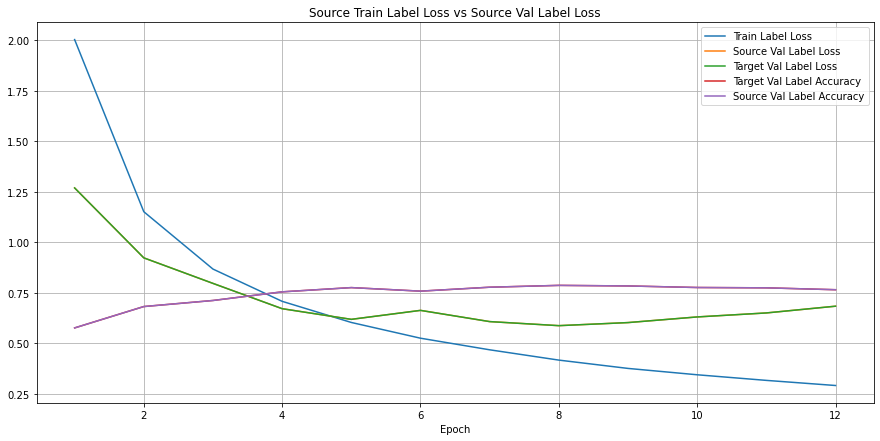

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

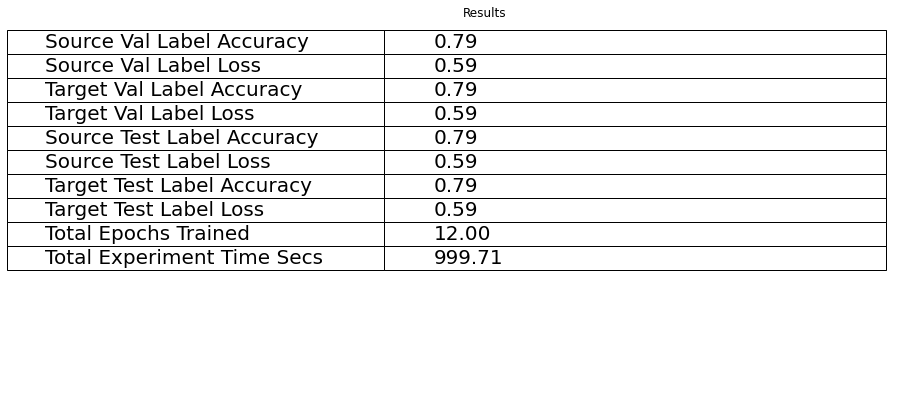

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

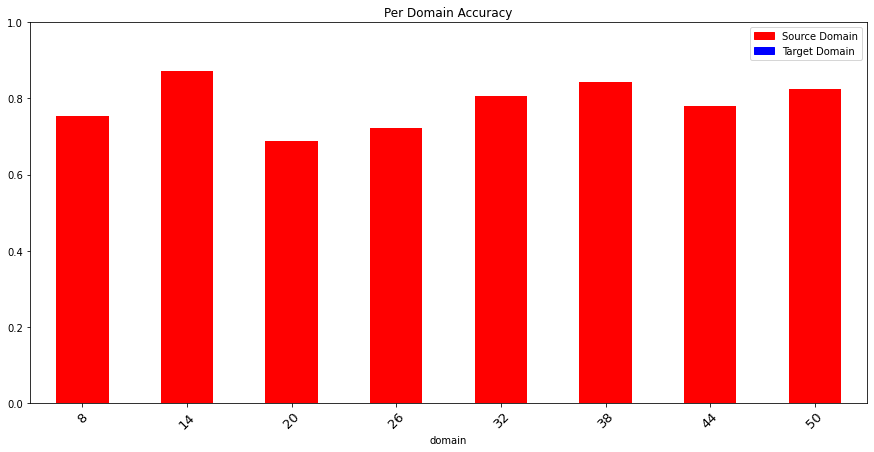

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.785609375 Target Test Label Accuracy: 0.785609375
Source Val Label Accuracy: 0.7861458333333333 Target Val Label Accuracy: 0.7861458333333333


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run1", "parameters": {"experiment_name": "cnn_2:oracle.run1", "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [